## Все метрики так же рассчитаны и визуализированны в Redash
Ссылка:
https://redash.lab.karpov.courses/dashboards/2377-a_iakovlev_final

In [1]:
import pandas as pd
import numpy as np
import pandahouse as ph
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.ticker import FuncFormatter


Загружаем данные из ClickHouse

In [2]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [3]:
q = '''
    SELECT 
        number_order,
        coalesce(date_order, 'NA') as date_order,
        coalesce(planned_data_order, 'NA') as planned_date_order,
        coalesce(result_data_order, 'NA') as result_date_order,
        carrier_name,
        warehouse_cluster,
        customer_cluster,
        timeslot_number,
        order_status,
        delivery_type,
        seller_ID
        FROM {db}.logistics_online
'''

In [4]:
logistics = ph.read_clickhouse(query=q, connection = connection_default)

In [5]:
q_1 = '''
    SELECT * 
        FROM {db}.product_online
'''

In [6]:
products = ph.read_clickhouse(query=q_1, connection = connection_default)

In [7]:
logistics.head()

,number_order,date_order,planned_date_order,result_date_order,carrier_name,warehouse_cluster,customer_cluster,timeslot_number,order_status,delivery_type,seller_ID
0,313655114,2021-5-01,2021-14-01,2021-11-01,3PL 1,Кластер Москва,Кластер Краснодар,1,Доставлен,Самовывоз,301202
1,315229153,2021-3-01,2021-11-01,2021-8-01,Самодоставка,Кластер Московская область,Кластер Московская область,1,Доставлен,Курьер,40560
2,3114106095,2021-8-01,2021-16-01,2021-14-01,Самодоставка,Кластер Московская область,Кластер Московская область,1,Доставлен,Курьер,40560
3,31145541407,2021-12-01,2021-20-01,2021-15-01,3PL 1,Кластер Москва,Кластер Санкт-Петербург,1,Доставлен,Самовывоз,301202
4,325050136,2021-16-01,2021-26-01,2021-25-01,3PL 1,Кластер Санкт-Петербург,Кластер Санкт-Петербург,1,Доставлен,Самовывоз,946233


In [8]:
q_2 = '''
    SELECT * 
        FROM {db}.returns_online
'''

In [9]:
returns = ph.read_clickhouse(query=q_2, connection = connection_default)

In [10]:
returns.head(3)

,number_order,product_ID,amount_return,return_date
0,3031410942,983588011,1,1970-01-01
1,31014374140,983586554,1,2021-07-01
2,3147145173,983589156,1,2021-11-01


In [12]:
products.head()

,number_order,product_ID,product_price,amount
0,313655114,983587801,5512.44,1
1,313655114,983587158,4070.35,2
2,313655114,983582669,3591.97,1
3,315229153,983589424,4433.23,3
4,315229153,983587827,2862.50,2


# Предобработка и очистка данных

###### Проверим основные правила, которые должны соблюдаться в данных:
Для данных о логистике
1. Номера заказов не должны повторяться в один и тот же временной слот.
2. У всех заказов, должен быть первый временной слот
3. Планируемая и реальная дата доставки должна быть позднее, чем дата заказа.

Для данных о покупке и возврате
4. количество возвращенных вещей не должно превышать количество купленных
5. Дата возврата должна быть позже даты получения товара




### Предобработка и очиста данных логистики

#### 1 Посмотрим есть ли заказы без первого таймслота

Для этого сгруппируем данные по номеру заказа (number_order), далее для каждого номера заказа находим минимальное значение timeslot_number. Если минимальное значение timeslot_number больше одного, значит для этого заказа в данных не записан первый временной слот.

In [13]:
orders_without_first_timeslot = logistics.groupby('number_order', as_index=False) \
    .agg({'timeslot_number':'min'}) \
    .rename(columns={'timeslot_number':'min'}) \
    .query('min > 1').number_order.values

logistics[logistics.number_order.isin(orders_without_first_timeslot)]

,number_order,date_order,planned_date_order,result_date_order,carrier_name,warehouse_cluster,customer_cluster,timeslot_number,order_status,delivery_type,seller_ID
2060,33196141469,NA,2021-23-02,2021-24-02,3PL 2,Кластер Санкт-Петербург,Кластер Краснодар,2,Доставлен,Самовывоз,946233
2099,3039114625,NA,2021-5-01,2020-31-012,3PL 2,Кластер Москва,Кластер Екатеринбург,2,Доставлен,Самовывоз,68503
3093,304073092,NA,2021-5-01,2021-8-01,3PL 2,Кластер Краснодар,Кластер Калининград,2,Доставлен,Самовывоз,93233
3290,300232595,NA,2021-5-01,2020-31-012,3PL 2,Кластер Москва,Кластер Новосибирск,2,Доставлен,Самовывоз,68503
5138,3399142241,NA,2021-22-03,NA,3PL 2,Кластер Екатеринбург,Кластер Московская область,2,На пути к клиенту,Самовывоз,833469
5279,21414577700,NA,2021-31-01,2021-1-02,Самодоставка,Кластер Екатеринбург,Кластер Москва,2,Доставлен,Курьер,120629
6180,302073096,NA,2021-5-01,2021-5-01,3PL 2,Кластер Екатеринбург,Кластер Московская область,2,Доставлен,Самовывоз,833469
6359,302459167,NA,2021-5-01,2021-5-01,3PL 2,Кластер Новосибирск,Кластер Центр,2,Доставлен,Самовывоз,923125


Для заказов с пропущенным первым временным слотом мы не сможем рассчитать большинство метрик из-за того что время заказа записывается именно в первом временном слоте. Поэтому мы удалим заказы без первого временного слота из дальнейшего анализа.

In [14]:
logistics.drop(    
    logistics[logistics.number_order.isin(orders_without_first_timeslot)].index,
    inplace=True
)

Так же проверяем наличие явныз дубликатов, и удаляем их

In [15]:
logistics.duplicated().sum()

1

In [16]:
logistics.drop_duplicates(inplace=True)

Далее находим заказы, в которых дублирутся номера заказаов в однм и том же временном слоте. Для этого группируем данные по номеру заказа и считаем количество строк. Ниже представлен код, для поиска повторов в первом тайм слоте. 

In [17]:
duplicqted_orders_id = logistics.query('timeslot_number == 1').number_order.value_counts().reset_index() \
    .rename(columns=({'index':'number_order', 'number_order':'count'})) \
    .query('count > 1').number_order.tolist()

logistics[logistics.number_order.isin(duplicqted_orders_id)]

,number_order,date_order,planned_date_order,result_date_order,carrier_name,warehouse_cluster,customer_cluster,timeslot_number,order_status,delivery_type,seller_ID
12,336693909,2021-9-02,2021-16-02,2021-17-02,3PL 3,Кластер Московская область,Кластер Екатеринбург,1,Доставлен,Самовывоз,2345336
13,336693909,2021-11-02,2021-16-02,2021-17-02,3PL 3,Кластер Московская область,Кластер Екатеринбург,1,Доставлен,Самовывоз,2345336
449,357469624,2021-4-03,2021-12-03,NA,3PL 3,Кластер Москва,Кластер Краснодар,1,Отменен,Курьер,8612129
450,357469624,2021-5-03,2021-12-03,NA,3PL 3,Кластер Москва,Кластер Краснодар,1,Отменен,Курьер,8612129
6426,333776216,2021-5-02,2021-11-02,2021-13-02,3PL 1,Кластер Екатеринбург,Кластер Санкт-Петербург,1,Доставлен,Самовывоз,633129
6427,333776216,2021-6-02,2021-11-02,2021-13-02,3PL 1,Кластер Екатеринбург,Кластер Санкт-Петербург,1,Доставлен,Самовывоз,633129
6428,333776216,NA,2021-12-02,2021-13-02,3PL 1,Кластер Екатеринбург,Кластер Санкт-Петербург,2,Доставлен,Самовывоз,633129


Во всех этих заказах дата доставки была позже запланированной. Одако не был предложен новый временной слот с более поздним планируемым времененм даставки. 
Вероятно, ошибка возникла из-за того, что вместо записи заказа с новым временным слотом, дублировалась исходная запись заказа.

Так как таких заказов было не много, поэтому мы удалим их из анализа.

In [18]:
logistics.drop(
    logistics[logistics.number_order.isin(duplicqted_orders_id)].index,
    inplace=True
)

В дргих таймслотах повторов не было

#### Преобразуем даты в формат datetime в данных о логистике

Сейчас дата заказа указана только в первом таймслоте. Добавим дату заказа для дургих таймслотов. Это потребудется для расчета метрики OnTime  сразбивкой по тайслотам.

In [19]:
try:
    for index in logistics.query('date_order == "NA"').index:
        n_order = logistics.loc[index,'number_order'].item()
        logistics.loc[index,'date_order'] = logistics.query('number_order == @n_order & timeslot_number ==1').date_order.item()
except:
    print(index)

In [20]:
logistics.head(5)

,number_order,date_order,planned_date_order,result_date_order,carrier_name,warehouse_cluster,customer_cluster,timeslot_number,order_status,delivery_type,seller_ID
0,313655114,2021-5-01,2021-14-01,2021-11-01,3PL 1,Кластер Москва,Кластер Краснодар,1,Доставлен,Самовывоз,301202
1,315229153,2021-3-01,2021-11-01,2021-8-01,Самодоставка,Кластер Московская область,Кластер Московская область,1,Доставлен,Курьер,40560
2,3114106095,2021-8-01,2021-16-01,2021-14-01,Самодоставка,Кластер Московская область,Кластер Московская область,1,Доставлен,Курьер,40560
3,31145541407,2021-12-01,2021-20-01,2021-15-01,3PL 1,Кластер Москва,Кластер Санкт-Петербург,1,Доставлен,Самовывоз,301202
4,325050136,2021-16-01,2021-26-01,2021-25-01,3PL 1,Кластер Санкт-Петербург,Кластер Санкт-Петербург,1,Доставлен,Самовывоз,946233


Как видно из таблицы, дата указана в необычном формате: ГОД-ДЕНЬ-МЕСЯЦ. Формат кажется необычным, и потенциально может привести к ошибкам при переводе из формата string в datetime.

Переведем дату из формата string в формат datetime, и сохраним значения, которые будут конвертироваться с ошибкой:

In [21]:
#создаем пустой лист
dates_with_errors = []

for row in logistics['date_order']:
    try:
        pd.to_datetime(row, format='%Y-%d-%m')
    except:
        #записываем значения, которые выдают ошибку при форматировании в лист
        dates_with_errors.append(row)

In [22]:
dates_with_errors

['2020-28-012',
 '2020-27-012',
 '2020-30-012',
 '2020-31-012',
 '2020-25-012',
 '2020-28-012',
 '2020-30-012',
 '2020-29-012',
 '2020-26-012',
 '2020-28-012',
 '2020-25-012',
 '2020-24-012',
 '2020-21-012',
 '2020-30-012',
 '2020-31-012',
 '2020-30-012',
 '2020-27-012',
 '2020-24-012',
 '2020-24-012',
 '2020-30-012',
 '2020-31-012',
 '2020-25-012',
 '2020-31-012',
 '2020-22-012',
 '2020-26-012',
 '2020-29-012',
 '2020-31-012',
 '2020-31-012',
 '2020-31-012',
 '2020-23-012',
 '2020-28-012',
 '2020-28-012',
 '2020-31-012',
 '2021-01-002']

В ряде случаев месяц записывался в в иде трех значений, например '012' или '002'. Чтобы эти значения считывались верно, нам нужно убрать ноль, который стоит в самом начале так чтобы из '002' получить '02':

In [23]:
#если значение дня, месяца или года начинается с нуля, то удаляем этот ноль
logistics['date_order'] = logistics['date_order'].apply(lambda x: x.replace('-0','-')) 

Переводим столбцы с даной в формате datetime.

In [24]:
logistics['date_order'] = pd.to_datetime(logistics['date_order'], format ='%Y-%d-%m')
logistics['planned_date_order'] = pd.to_datetime(logistics['planned_date_order'], format ='%Y-%d-%m')
logistics['result_date_order'] = pd.to_datetime(logistics['result_date_order'], format ='%Y-%d-%m', errors = 'coerce')

#### Преобразуем даты в формат datetime в данных о возвратах

In [25]:
returns.head()

,number_order,product_ID,amount_return,return_date
0,3031410942,983588011,1,1970-01-01
1,31014374140,983586554,1,2021-07-01
2,3147145173,983589156,1,2021-11-01
3,3141464669,983589362,1,2021-11-01
4,3131450699,983589729,3,2021-12-01


In [26]:
returns.dtypes

number_order              int64
product_ID                int64
amount_return              int8
return_date      datetime64[ns]
dtype: object

В первой же строке указана дата возврата - 1970 год. Это минимальный год в формате UNIX. Так же SQL выдает такой год, если неправильно перевести string в date. Так, если я возьму дату формата String, записанную как "YYYY-DD-MM", и в ClickHouse переведу ее в формате date, то получу 1970 год. Например, запрос toDate('2021-17-01') в ClickHouse вернет 1970-01-01.
Из этого можно предположить, что в таблице "returns" дата была записана в формате string "YYYY-DD-MM", и ктозто ее ошибочно перевел в формат Date с неверным порядком месяца и года. Из-за этого все данные, записанные после 12-го числа каждого месяца по-сути потеряны. 

In [27]:
display(returns.return_date.value_counts().head())
display(returns.shape)

1970-01-01    253
2021-05-03     31
2021-04-03     20
2021-07-03     18
2021-11-03     17
Name: return_date, dtype: int64

(496, 4)

Получается 253 строк из 496 придется удалить. Так как это около 50% от данных о возвратах, это сильно исказит динамику метрик "Return Rate" и "GMV D-R" по дням. Сравнение данных метрик по перевозчикам, складам и пр. будет адекватным, так как там не ичпользуется дата.

Переведем "return_date" в правильный формат даты следующим образом: datetime преобразуем в string, и из string обратно в datetime, но уже с правильным указанием месяца и года.

In [28]:
returns['return_date'] = pd.to_datetime(returns['return_date'].astype(str), format ='%Y-%d-%m')

### Проверим ошибки в записи времени заказа и доставки

Проверим соблюдается ли условие, что дата заказа должна быть раньше даты планируемой и реальной доставки

In [29]:
sum(logistics['date_order'] > logistics['planned_date_order'])

0

In [30]:
sum(logistics['date_order'] > logistics['result_date_order'])

925

In [31]:
#посчитаем общее количество заказов
logistics.number_order.nunique()

5965

Получается в 925 заказах из 5965 дата доставки оказалась раньше даты заказа. При этом дата планируемой доставки указана без ошибок. Значит с ошибкой была указанна именно дата доставки. Попробуем найти почему и где эти ошибки возникли в фактической дате доставки.

In [32]:
# сделаем копию данных о логистике
error_data = logistics.copy(deep=True)

In [33]:
error_data.drop(
error_data[error_data.result_date_order.isna()].index, inplace=True
)

In [34]:
#Создадим столбец, где будут помечены строки с ошибкой в дате доставки
error_data['errors'] = (error_data['date_order'] > error_data['result_date_order'])

In [35]:
#Посчитаем метрику Click2Delivery, чтобы понимать размер ошибки в дате доставки
error_data['C2D'] = error_data['result_date_order'] - error_data['date_order']
error_data['C2D'] = error_data['C2D'].dt.days

Проверим, как распределены заказы с ошибкой в дате доставки во времени

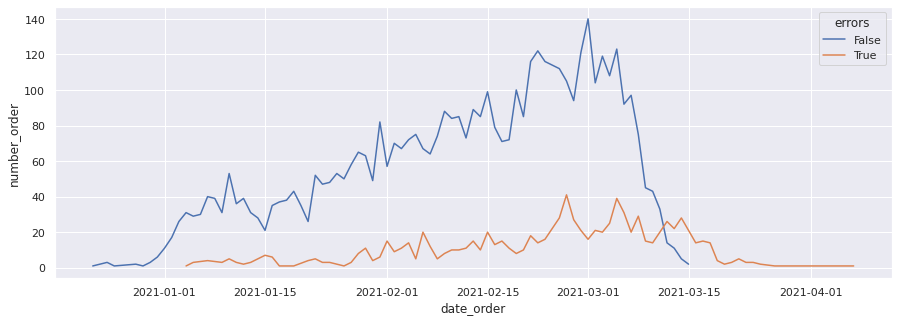

In [36]:
sns.set(rc={'figure.figsize':(15,5)})

sns.lineplot(data = error_data.groupby(['date_order','errors'], as_index=False).number_order.count()
    .sort_values('errors', ascending=False), x='date_order', y='number_order', hue = 'errors')
plt.show()

Как видно из графика, ошибка появлялась в заказах на протяжении почти всего времени. Значит ошибка - это не разовый сбой в системе записи данных. Возможно у какой-то службы доставки неправильно настроено оборудование (время на компьютере).

Посмотрим, в каких клвстерах чаще всего появлялась ошибка. 

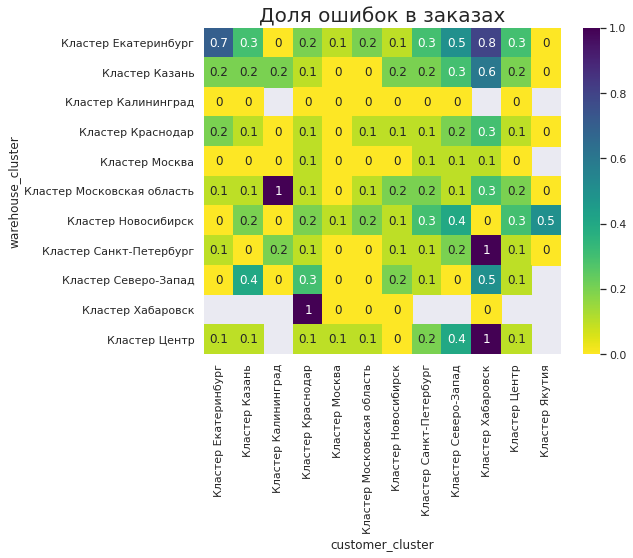

In [37]:
# Группируем данные по складу продавца и покупателя, и считаем долю ошибок 
error_by_cluster = error_data \
    .groupby(['warehouse_cluster', 'customer_cluster'], as_index=False).errors.mean() \
    .sort_values('errors', ascending=True)
error_by_cluster['errors'] = error_by_cluster.errors.round(1)


sns.set(rc={'figure.figsize':(8,6)})
# переводим данные в фид сводной таблицы и визуализируем в Heatmap
sns.heatmap( 
            error_by_cluster.pivot(index='warehouse_cluster', 
                                  columns = 'customer_cluster', 
                                  values = 'errors'), 
            annot=True,
            cmap="viridis_r").axes.set_title("Доля ошибок в заказах",fontsize=20)
plt.show()

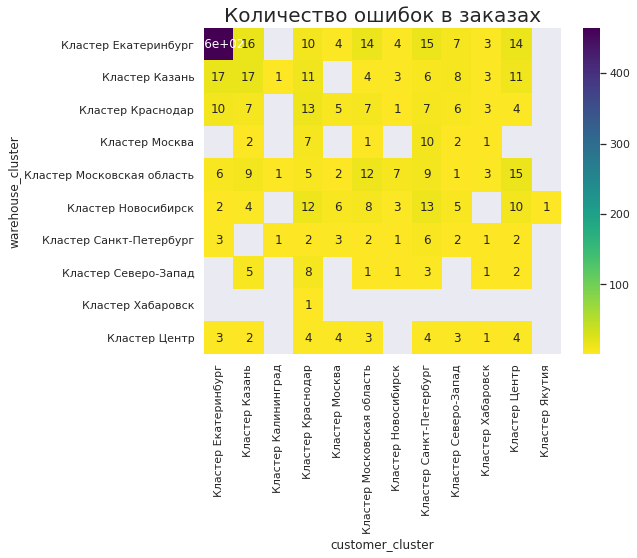

In [38]:
sns.set(rc={'figure.figsize':(8,6)})

error_by_cluster_abs = error_data.query('errors == True') \
    .groupby(['warehouse_cluster', 'customer_cluster'], as_index=False).C2D.count() \
    .sort_values('C2D', ascending=True)
sns.heatmap( 
            error_by_cluster_abs.pivot(index='warehouse_cluster', 
                                  columns = 'customer_cluster', 
                                  values = 'C2D'), 
            annot=True,
            cmap="viridis_r").set_title("Количество ошибок в заказах",fontsize=20)
plt.show()

В абсолютном значении больше всего ошибок в датах доставки было в заказах внутри Екатеринбурга. В процентном соотношении, больший процент ошибок был в ряде кластеров с единичными заказами (от 1 до 4 заказов)

В озон дата доставки указывается автоматически во всех случаях кроме доставки по схеме RealFBS, когда доставку не осуществляет партнер Ozon. Поэтому можно предположить, что чаще всего ошибкти будут при "самодоставке".

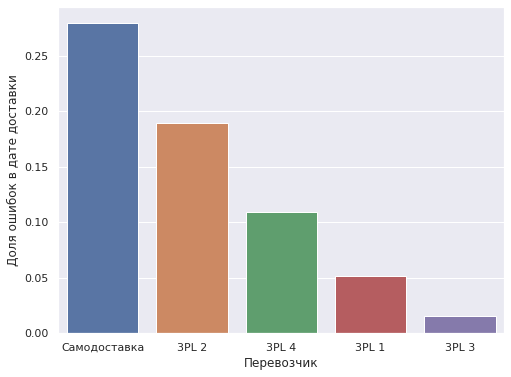

In [39]:
p = sns.barplot(data=error_data.groupby(['carrier_name'], as_index=False).errors.mean() \
    .sort_values('errors', ascending=False), x='carrier_name', y='errors')
p.set_xlabel("Перевозчик",fontsize=12)
p.set_ylabel("Доля ошибок в дате доставки",fontsize=12)
plt.show()

Наибольшая доля ошибок была у "самодоставки", однако у других перевозчиков тоже есть часть заказов, где дата доставки указана не верно.

Так же проверим долю ошибок по типу доставки

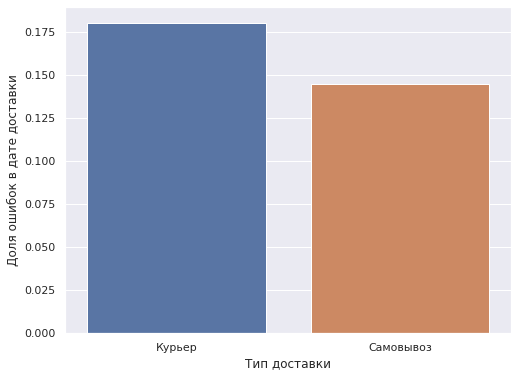

In [40]:
p = sns.barplot(data=error_data.groupby(['delivery_type'], as_index=False).errors.mean() \
    .sort_values('errors', ascending=False), x='delivery_type', y='errors')
p.set_xlabel("Тип доставки",fontsize=12)
p.set_ylabel("Доля ошибок в дате доставки",fontsize=12)
plt.show()

Так же проверим, количество ошибок среди продавцов по типу доставки

In [41]:
error_data.groupby(['seller_ID','carrier_name'], as_index=False).errors.sum() \
    .sort_values('errors', ascending=False).head(10)

,seller_ID,carrier_name,errors
162,902912,Самодоставка,455
20,19923,3PL 2,57
40,41958,3PL 2,46
152,833469,3PL 2,32
32,33900,3PL 2,28
98,120629,Самодоставка,27
66,64865,3PL 2,21
151,833469,3PL 1,18
154,855433,3PL 1,16
165,923125,3PL 2,15


In [42]:
error_data.query('carrier_name == "Самодоставка"').groupby(['seller_ID'], as_index=False).agg(
    sum_errors = ('errors', np.sum),
    mean_errors = ('errors', np.mean)
).sort_values('mean_errors', ascending=False).query('mean_errors > 0')


,seller_ID,sum_errors,mean_errors
13,52332,1,1.000000
33,339296,1,1.000000
30,332334,2,1.000000
29,239238,2,1.000000
43,864012,2,1.000000
23,120629,27,0.818182
44,902912,455,0.789931
32,339242,2,0.666667
35,343365,1,0.090909
10,44212,1,0.083333


Всего 11 проодавцов совершали ошибки, когда указывали реальную дату доставки. Наибольшая доля ошибок в дате доставки приходится на продавца № 902912.

In [43]:
#Удалим данные продавца №902912 и №120629, так как мы не можем доверять данным, которые они указывали
logistics.drop(    
    logistics[(logistics['seller_ID']==902912) | (logistics['seller_ID']==120629)].index,
    inplace=True
)

Далее проверим, ошибки в указанной доет доставки у перевозчиков

In [44]:
error_data.query('carrier_name != "Самодоставка"').groupby(['customer_cluster', 'carrier_name','warehouse_cluster'], as_index=False).agg(
    sum_errors = ('errors', np.sum),
    mean_errors = ('errors', np.mean)
) \
    .sort_values('mean_errors', ascending=False).query('mean_errors > 0.8')

,customer_cluster,carrier_name,warehouse_cluster,sum_errors,mean_errors
246,Кластер Хабаровск,3PL 2,Кластер Санкт-Петербург,1,1.0
97,Кластер Краснодар,3PL 4,Кластер Краснодар,1,1.0
69,Кластер Калининград,3PL 4,Кластер Санкт-Петербург,1,1.0
88,Кластер Краснодар,3PL 2,Кластер Хабаровск,1,1.0
66,Кластер Калининград,3PL 2,Кластер Московская область,1,1.0
269,Кластер Центр,3PL 2,Кластер Центр,1,1.0
231,Кластер Северо-Запад,3PL 2,Кластер Центр,1,1.0
90,Кластер Краснодар,3PL 3,Кластер Казань,1,1.0
249,Кластер Хабаровск,3PL 2,Кластер Центр,1,1.0


В целом, у перевозчиков нет систематических ошибок в указании даты фактической доставки. Поэтому мы оставим данные всех перевозчиков, и уберем только отдельные заказы с ошибочной датой доставки.

In [45]:
logistics['date_error'] = logistics['date_order'] > logistics['result_date_order']
logistics.drop(    
    logistics[logistics['date_error']==True].index,
    inplace=True
)

## 1. Посчитать OnTime - Метрика своевременности доставки. (Доставили в плановую дату доставки или нет), в %

 - Необходимо видеть изменение метрики по дням;

 - Необходимы разрезы по перевозчикам, по типу доставки, по кластерам склада, по таймслотам;

In [46]:
# Удалим заказы , которые еще не были доставлены и сохраним в новую переменную
# При сравнении метрик важно, чтобы они рассчитывались на схожих данных. Поэтому мы оставляем только те данные, которые подойдут
# Для расчета и PromisedClick2Delivery и Click2Delivery

logistics_without_na_dates = logistics.drop(    
    logistics[logistics.result_date_order.isna()].index
)

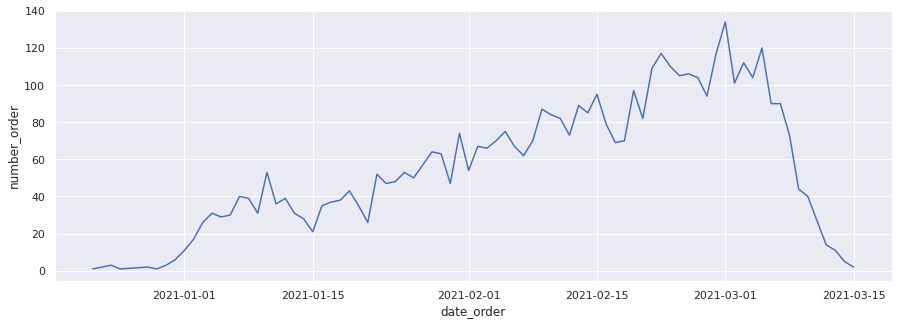

In [47]:
sns.set(rc={'figure.figsize':(15,5)})

sns.lineplot(data = logistics_without_na_dates.groupby(['date_order'], as_index=False).number_order.count(), 
             x='date_order', y='number_order')
plt.show()

Количество заказов начинается от нуля в конце 2020 года, далее увеличивается и в начале марта 2021 года резко снижается до нуля. Скорее такая динамика это связанно с осоенностью того, как выгружался данный датасет.Данную динамику нужно учитывать при анализе показателей метрик, как как данный тренд в количестве заказов будет на них влиять. 

In [48]:
#Функция, которая ставит 1, если заказ был доставлел в плановую дату и 0, если нет
def on_time(row):
    if row['planned_date_order'] == row['result_date_order']:
        return 1
    else:
        return 0

In [49]:
#применяем функцию к данным
logistics_without_na_dates['on_time'] = logistics_without_na_dates.apply(on_time, axis=1)

In [50]:
logistics_without_na_dates.head(3)

,number_order,date_order,planned_date_order,result_date_order,carrier_name,warehouse_cluster,customer_cluster,timeslot_number,order_status,delivery_type,seller_ID,date_error,on_time
0,313655114,2021-01-05,2021-01-14,2021-01-11,3PL 1,Кластер Москва,Кластер Краснодар,1,Доставлен,Самовывоз,301202,False,0
1,315229153,2021-01-03,2021-01-11,2021-01-08,Самодоставка,Кластер Московская область,Кластер Московская область,1,Доставлен,Курьер,40560,False,0
2,3114106095,2021-01-08,2021-01-16,2021-01-14,Самодоставка,Кластер Московская область,Кластер Московская область,1,Доставлен,Курьер,40560,False,0


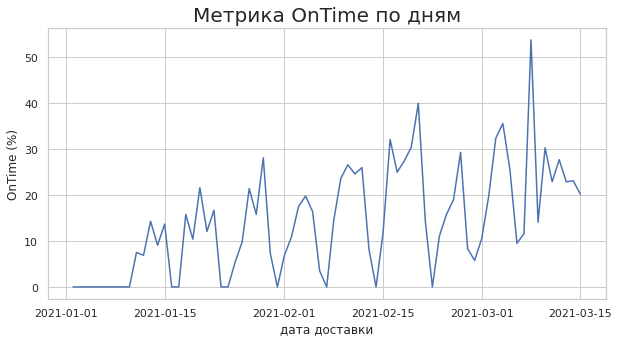

In [51]:

sns.set(rc={'figure.figsize':(10,5)})
sns.set_style("whitegrid")
# группируем данные по времени доставки, и считаем долю заказов доставленных вовремя
on_time_by_planned_date = logistics_without_na_dates.groupby('result_date_order', as_index=False).on_time.mean()

#домножаем эту долю на 100, чтобы получить проценты
on_time_by_planned_date['on_time'] = on_time_by_planned_date['on_time'].apply(lambda x: round(x*100,1))

# и строим график
p = sns.lineplot(data = on_time_by_planned_date, x='result_date_order', y = 'on_time')
p.set_title("Метрика OnTime по дням",fontsize=20)
p.set_xlabel("дата доставки",fontsize=12)
p.set_ylabel("OnTime (%)",fontsize=12)
plt.show()

Динамика метрики OnTime по дням показывает растущий тренд. Это может говорить о том, что алгоритмы. которые предсказывают дату доставки, становятся все лучше. Так же на графике видны резкие спады метрики до нуля на выходных. Вероятно это связано с тем, что планируемая дата доставки редко выпадает на выходные, в отличие то фактической даты доставки (как видно на графике ниже) 

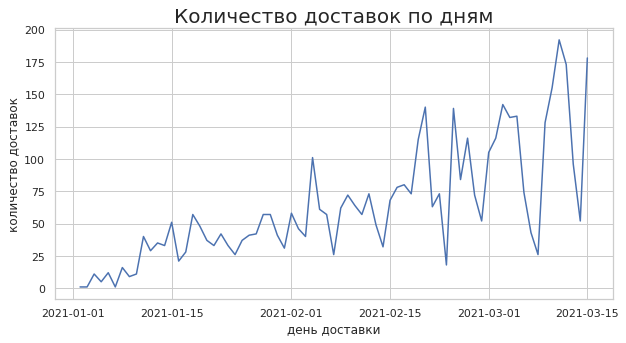

In [52]:
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style("whitegrid")

on_time_by_planned_date = logistics_without_na_dates.groupby('result_date_order', as_index=False).number_order.count()
p = sns.lineplot(data = on_time_by_planned_date, x='result_date_order', y = 'number_order')
p.set_title("Количество доставок по дням",fontsize=20)
p.set_xlabel("день доставки",fontsize=12)
p.set_ylabel("количество доставок",fontsize=12)
plt.show()

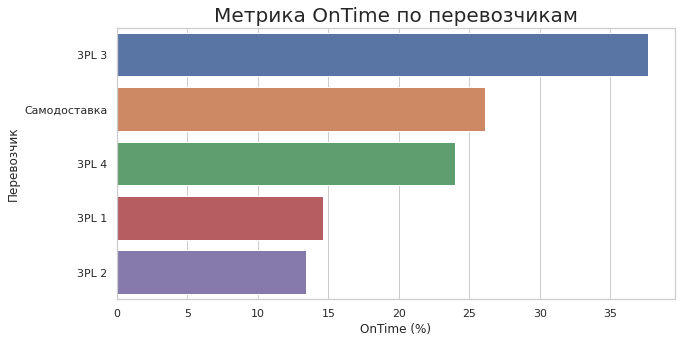

In [53]:
on_time_by_carrier_name  = logistics_without_na_dates.groupby('carrier_name', as_index=False).on_time.mean().sort_values('on_time', ascending=False)
on_time_by_carrier_name['on_time'] = on_time_by_carrier_name['on_time'].apply(lambda x: round(x*100,1))
p = sns.barplot(data = on_time_by_carrier_name, y='carrier_name', x = 'on_time')
p.set_title("Метрика OnTime по перевозчикам",fontsize=20)
p.set_xlabel("OnTime (%)",fontsize=12)
p.set_ylabel("Перевозчик",fontsize=12)
plt.show()


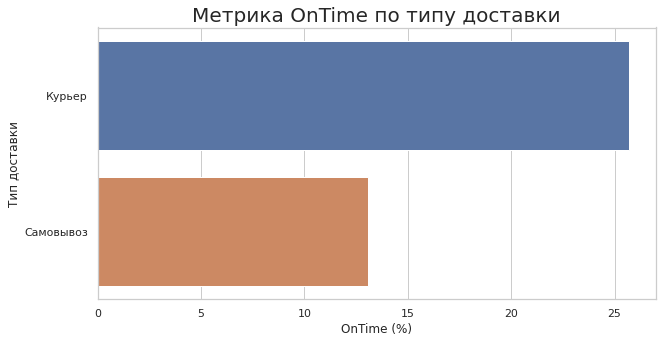

In [54]:
on_time_by_delivery_type  = logistics_without_na_dates.groupby('delivery_type', as_index=False).on_time.mean().sort_values('on_time', ascending=False)
on_time_by_delivery_type['on_time'] = on_time_by_delivery_type['on_time'].apply(lambda x: round(x*100,1))
p = sns.barplot(data = on_time_by_delivery_type, y='delivery_type', x = 'on_time')
p.set_title("Метрика OnTime по типу доставки",fontsize=20)
p.set_xlabel("OnTime (%)",fontsize=12)
p.set_ylabel("Тип доставки",fontsize=12)
plt.show()

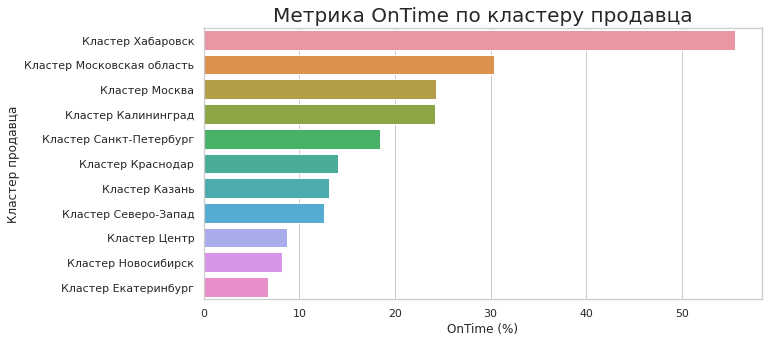

In [55]:
on_time_by_warehouse_cluster  = logistics_without_na_dates.groupby('warehouse_cluster', as_index=False).on_time.mean().sort_values('on_time', ascending=False)
on_time_by_warehouse_cluster['on_time'] = on_time_by_warehouse_cluster['on_time'].apply(lambda x: round(x*100,1))
p = sns.barplot(data = on_time_by_warehouse_cluster, y='warehouse_cluster', x = 'on_time')
p.set_title("Метрика OnTime по кластеру продавца",fontsize=20)
p.set_xlabel("OnTime (%)",fontsize=12)
p.set_ylabel("Кластер продавца",fontsize=12)
plt.show()

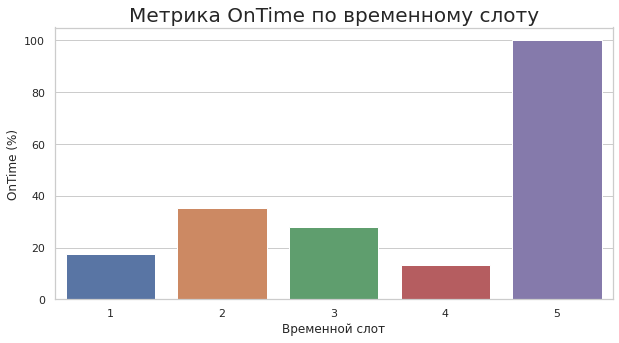

In [56]:
on_time_by_timeslot_number  = logistics_without_na_dates.groupby('timeslot_number', as_index=False).on_time.mean().sort_values('on_time', ascending=False)
on_time_by_timeslot_number['on_time'] = on_time_by_timeslot_number['on_time'].apply(lambda x: round(x*100,1))
p = sns.barplot(data = on_time_by_timeslot_number, x='timeslot_number', y = 'on_time')
p.set_title("Метрика OnTime по временному слоту",fontsize=20)
p.set_xlabel("Временной слот",fontsize=12)
p.set_ylabel("OnTime (%)",fontsize=12)
plt.show()

## 2. Посчитать PromisedClick2Delivery - метрика обещанного срока доставки (от даты заказа до первой плановой даты доставки), в сутках.

 - Необходима динамика по дням, неделям, месяцам;

 - Необходимо сравнение перевозчиков;

 - Необходимо понимание уровня метрики из кластера в кластер.

Удалим данные, которые не подойдут для расчета метрик

In [57]:
#удалим все данные о доставках кроме первого временного слота. Далее они нам не понадобятся.

logistics_without_na_dates.drop(    
    logistics_without_na_dates[logistics_without_na_dates['timeslot_number'] != 1].index,
    inplace=True
)

In [58]:
# Рассчитаем метрики PromisedClick2Delivery и Click2Delivery
logistics_without_na_dates['PromisedClick2Delivery'] = logistics_without_na_dates['planned_date_order'] - logistics_without_na_dates['date_order']
logistics_without_na_dates['PromisedClick2Delivery'] = logistics_without_na_dates['PromisedClick2Delivery'].dt.days

logistics_without_na_dates['Click2Delivery'] = logistics_without_na_dates['result_date_order'] - logistics_without_na_dates['date_order']
logistics_without_na_dates['Click2Delivery'] = logistics_without_na_dates['Click2Delivery'].dt.days


Проверим, как выглядит распределение ожидаемого времени доставки

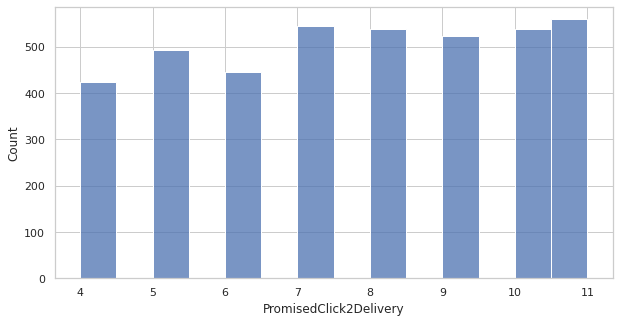

In [59]:
sns.histplot(logistics_without_na_dates['PromisedClick2Delivery'])

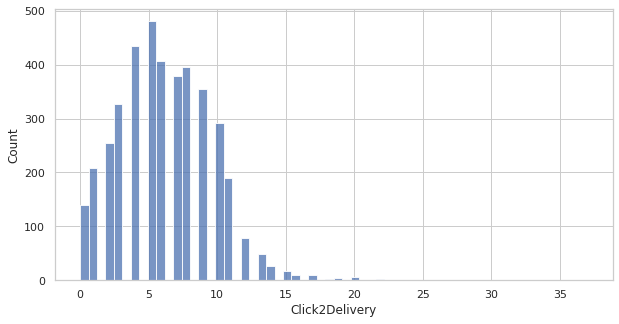

In [60]:
sns.histplot(logistics_without_na_dates['Click2Delivery'])

Планируемое и реальное время доставки имеют немного скошенные распределения, небольшой разброс,поэтому мы удалим выбросы и будем использовать среднее значение дня расчета PromisedClick2Delivery и Click2Delivery. Основное преимущество среднего значанения - возможность наблюдать изменения в десятичных долях в метрики.

In [61]:
# удаляем заказы, где Click2Delivery больше 20 дней
logistics_without_na_dates = logistics_without_na_dates[logistics_without_na_dates['Click2Delivery'] < 20]

###### Динамика по дням

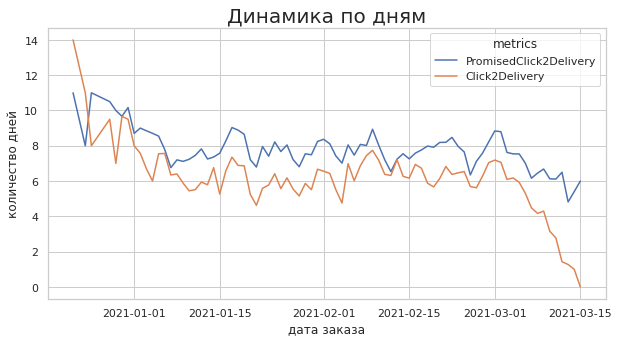

In [62]:
#группируем данные по дням и рассчитываем метрики
PC2D_days = logistics_without_na_dates.groupby('date_order', as_index=False).agg({'PromisedClick2Delivery':'mean', 'Click2Delivery':'mean'})

#Переводим таблицу в длинный формат
PC2D_days = PC2D_days.melt('date_order', var_name='metrics', value_name='days')

p = sns.lineplot(data=PC2D_days, x='date_order', y = 'days', hue = 'metrics')
p.set_title("Динамика по дням",fontsize=20)
p.set_xlabel("дата заказа",fontsize=12)
p.set_ylabel("количество дней",fontsize=12)
plt.show()


Важно отметить, что по данному графику нельзя делать выводы, так как в некоторые дни был совершен всего один заказ, а в некоторые - больше 100.

###### Динамика по неделям


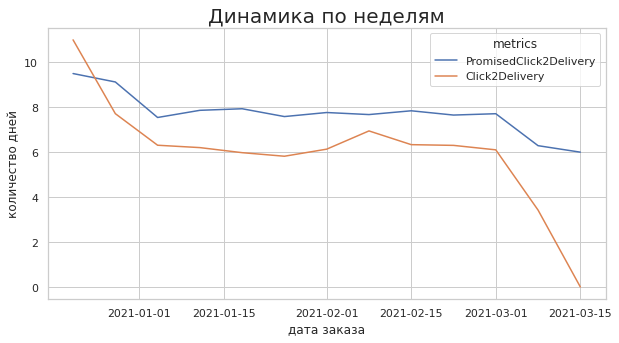

In [63]:
PC2D_weeks = logistics_without_na_dates
# Округляем дату до первого дня недели
PC2D_weeks['date_order'] = PC2D_weeks['date_order'].dt.to_period("W").dt.start_time
PC2D_weeks = PC2D_weeks.groupby('date_order', as_index=False).agg({'PromisedClick2Delivery':'mean', 'Click2Delivery':'mean'})
PC2D_weeks = PC2D_weeks.melt('date_order', var_name='metrics', value_name='days')


p = sns.lineplot(data=PC2D_weeks, x='date_order', y = 'days', hue = 'metrics')
p.set_title("Динамика по неделям",fontsize=20)
p.set_xlabel("дата заказа",fontsize=12)
p.set_ylabel("количество дней",fontsize=12)
plt.show()


###### Динамика по месяцам

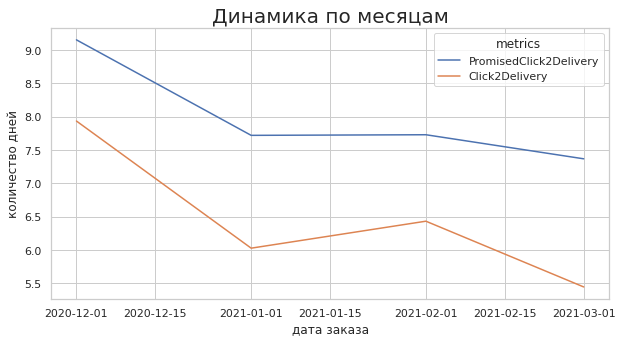

In [64]:
PC2D_month = logistics_without_na_dates
PC2D_month['date_order'] = PC2D_month['date_order'].dt.to_period("M").dt.start_time
PC2D_month = PC2D_month.groupby('date_order', as_index=False).agg({'PromisedClick2Delivery':'mean', 'Click2Delivery':'mean'})
PC2D_month = PC2D_month.melt('date_order', var_name='metrics', value_name='days')

p = sns.lineplot(data=PC2D_month, x='date_order', y = 'days', hue = 'metrics')

p.set_title("Динамика по месяцам",fontsize=20)
p.set_xlabel("дата заказа",fontsize=12)
p.set_ylabel("количество дней",fontsize=12)
plt.show()

###### сравнение перевозчиков

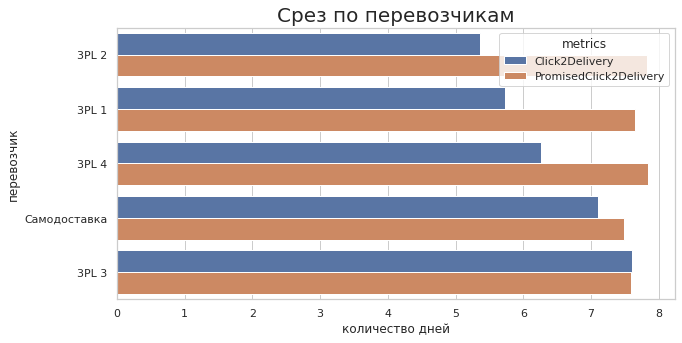

In [65]:

PC2D_by_carrier = logistics_without_na_dates.groupby('carrier_name', as_index=False) \
        .agg({'PromisedClick2Delivery':'mean', 'Click2Delivery':'mean'})
PC2D_by_carrier = PC2D_by_carrier.melt('carrier_name', var_name='metrics', value_name='days') \
        .sort_values('days', ascending=True)



p = sns.barplot(data=PC2D_by_carrier, y='carrier_name', x = 'days', hue = 'metrics')
p.set_title("Срез по перевозчикам",fontsize=20)
p.set_xlabel("количество дней",fontsize=12)
p.set_ylabel("перевозчик",fontsize=12)
plt.show()

###### сравнение по кластерам PromisedClick2Delivery

In [66]:
#считаем среднее значение PromisedClick2Delivery по кластерам продавца и покупателя
PC2D_by_cluster = logistics_without_na_dates.groupby(['warehouse_cluster', 'customer_cluster'], as_index=False) \
    .PromisedClick2Delivery.mean() \
    .sort_values('PromisedClick2Delivery', ascending=True)

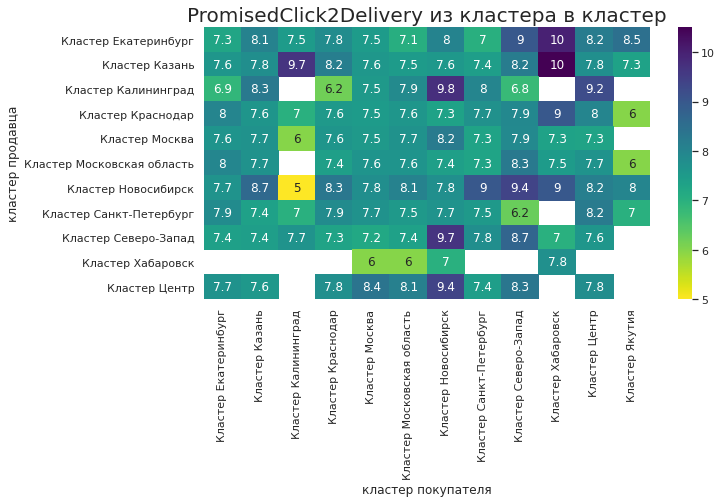

In [67]:
#делаем сводную таблицу и визуализируем
p = sns.heatmap( 
            PC2D_by_cluster.pivot(index='warehouse_cluster', 
                                  columns = 'customer_cluster', 
                                  values = 'PromisedClick2Delivery'), 
            annot=True,
            cmap="viridis_r")
p.set_title("PromisedClick2Delivery из кластера в кластер",fontsize=20)
p.set_xlabel("кластер покупателя",fontsize=12)
p.set_ylabel("кластер продавца",fontsize=12)
plt.show()

###### сравнение по кластерам: разница между предсказанным и реальным временем доставки


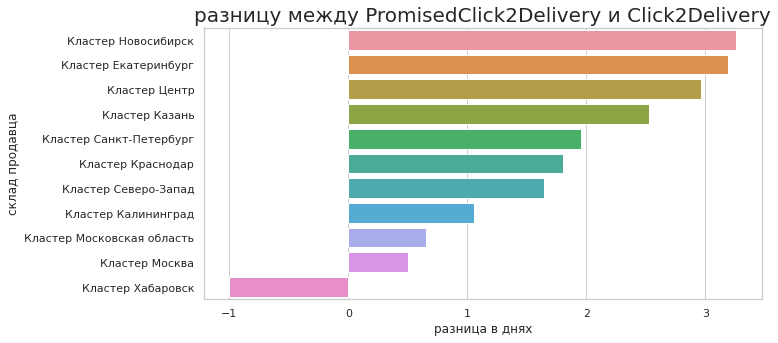

In [68]:
PC2D_C2D_dif_by_carrier = logistics_without_na_dates
#считаем разницу между метрикой PromisedClick2Delivery и Click2Delivery
PC2D_C2D_dif_by_carrier['PC2D_C2D_dif'] = PC2D_C2D_dif_by_carrier['PromisedClick2Delivery'] - PC2D_C2D_dif_by_carrier['Click2Delivery']

#считаем среднее значение разница по кластерам продавца
PC2D_C2D_dif_by_carrier = PC2D_C2D_dif_by_carrier.groupby('warehouse_cluster', as_index=False).agg({'PC2D_C2D_dif':'mean'}) \
    .sort_values('PC2D_C2D_dif', ascending=False)


p = sns.barplot(data=PC2D_C2D_dif_by_carrier, x='PC2D_C2D_dif', y = 'warehouse_cluster')
p.set_title("разницу между PromisedClick2Delivery и Click2Delivery",fontsize=20)
p.set_xlabel("разница в днях",fontsize=12)
p.set_ylabel("склад продавца",fontsize=12)
plt.show()


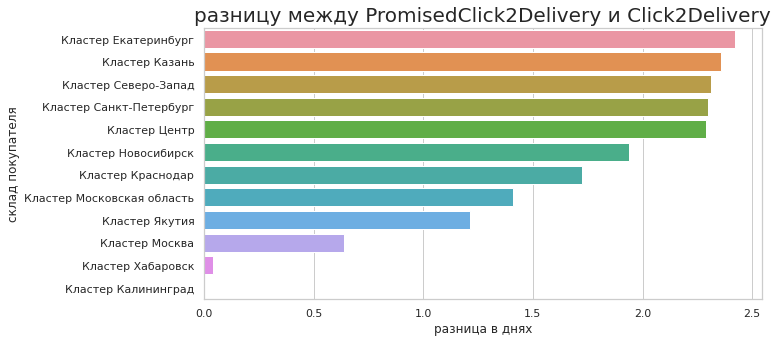

In [69]:
#делаем тоже самое для кластера покупателя
PC2D_C2D_dif_by_carrier = logistics_without_na_dates
PC2D_C2D_dif_by_carrier['PC2D_C2D_dif'] = PC2D_C2D_dif_by_carrier['PromisedClick2Delivery'] - PC2D_C2D_dif_by_carrier['Click2Delivery']

PC2D_C2D_dif_by_carrier = PC2D_C2D_dif_by_carrier.groupby('customer_cluster', as_index=False).agg({'PC2D_C2D_dif':'mean'}) \
    .sort_values('PC2D_C2D_dif', ascending=False)


p = sns.barplot(data=PC2D_C2D_dif_by_carrier, x='PC2D_C2D_dif', y = 'customer_cluster')
p.set_title("разницу между PromisedClick2Delivery и Click2Delivery",fontsize=20)
p.set_xlabel("разница в днях",fontsize=12)
p.set_ylabel("склад покупателя",fontsize=12)
plt.show()

## 4. Посчитать GMV Accepted - метрика совокупного объема продаж (считается по заказам, оформленным в указанный день), в рублях.

 - Необходимо видеть изменение метрики по дням;

 - Необходимы разрезы по перевозчикам, по типу доставки, по кластерам склада;

Для рассчета этой метрики нам понадобится соединить данные о логистике с данными о товарах. 

In [70]:
#соединяем данные по номеру заказа
logistics_and_products_merged = logistics.merge(products, on='number_order', how='left')

In [71]:
logistics_and_products_merged.head()

,number_order,date_order,planned_date_order,result_date_order,carrier_name,warehouse_cluster,customer_cluster,timeslot_number,order_status,delivery_type,seller_ID,date_error,product_ID,product_price,amount
0,313655114,2021-01-05,2021-01-14,2021-01-11,3PL 1,Кластер Москва,Кластер Краснодар,1,Доставлен,Самовывоз,301202,False,983587801,5512.44,1
1,313655114,2021-01-05,2021-01-14,2021-01-11,3PL 1,Кластер Москва,Кластер Краснодар,1,Доставлен,Самовывоз,301202,False,983587158,4070.35,2
2,313655114,2021-01-05,2021-01-14,2021-01-11,3PL 1,Кластер Москва,Кластер Краснодар,1,Доставлен,Самовывоз,301202,False,983582669,3591.97,1
3,315229153,2021-01-03,2021-01-11,2021-01-08,Самодоставка,Кластер Московская область,Кластер Московская область,1,Доставлен,Курьер,40560,False,983589424,4433.23,3
4,315229153,2021-01-03,2021-01-11,2021-01-08,Самодоставка,Кластер Московская область,Кластер Московская область,1,Доставлен,Курьер,40560,False,983587827,2862.50,2


In [72]:
# рассчитываем итоговую цену для каждого товара
logistics_and_products_merged['gmv_accepted'] = logistics_and_products_merged['product_price'] * \
    logistics_and_products_merged['amount']

Посчитаем динамику GMV Accepted по дням

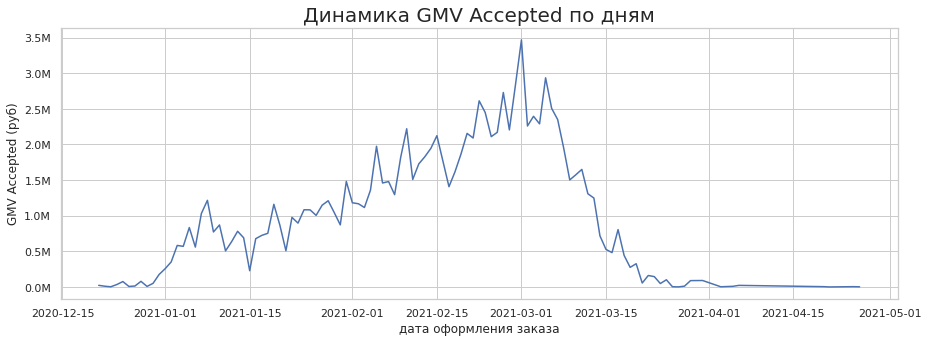

In [73]:
#задаем размеры и стиль графика
sns.set(rc={'figure.figsize':(15,5)})
sns.set_style("whitegrid")

#функция, которая переводит занчения на оси Y в миллионы
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)
formatter = FuncFormatter(millions)
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(formatter)

#сам график
p = sns.lineplot(
    data = logistics_and_products_merged.groupby('date_order', as_index=False).gmv_accepted.sum(),
    x='date_order', y='gmv_accepted'
)
p.set_title("Динамика GMV Accepted по дням",fontsize=20)
p.set_xlabel("дата оформления заказа",fontsize=12)
p.set_ylabel("GMV Accepted (руб)",fontsize=12)
plt.show()


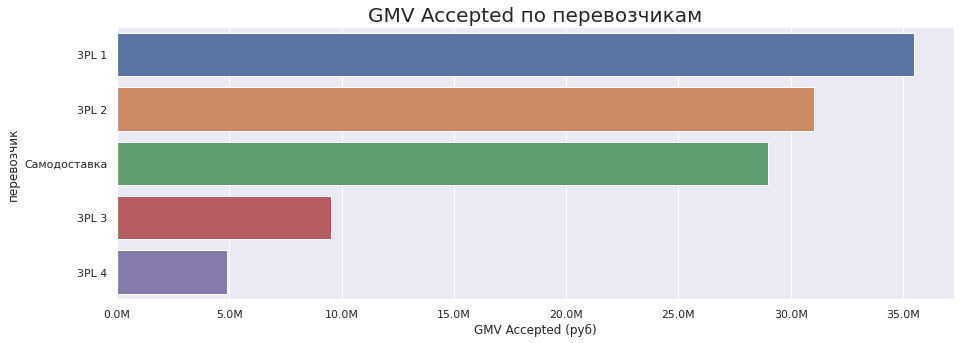

In [74]:
sns.set(rc={'figure.figsize':(15,5)})

#функция, которая переводит занчения на оси Y в миллионы
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)
formatter = FuncFormatter(millions)
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(formatter)


p = sns.barplot(
    data = logistics_and_products_merged.groupby('carrier_name', as_index=False).gmv_accepted.sum() \
        .sort_values('gmv_accepted', ascending=False),
    y='carrier_name', x='gmv_accepted'
)
p.set_title("GMV Accepted по перевозчикам",fontsize=20)
p.set_xlabel("GMV Accepted (руб)",fontsize=12)
p.set_ylabel("перевозчик",fontsize=12)
plt.show()

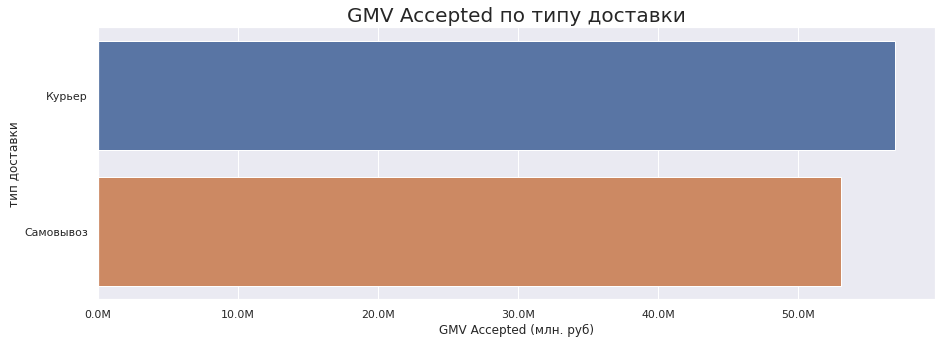

In [75]:
#функция, которая переводит занчения на оси Y в миллионы
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)
formatter = FuncFormatter(millions)
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(formatter)



p = sns.barplot(
    data = logistics_and_products_merged.groupby('delivery_type', as_index=False).gmv_accepted.sum() \
        .sort_values('gmv_accepted', ascending=False),
    y='delivery_type', x='gmv_accepted'
)
p.set_title("GMV Accepted по типу доставки",fontsize=20)
p.set_xlabel("GMV Accepted (млн. руб)",fontsize=12)
p.set_ylabel("тип доставки",fontsize=12)
plt.show()

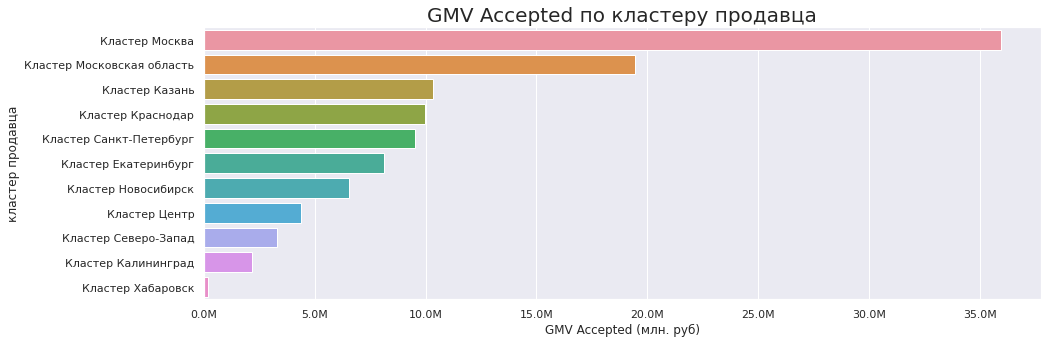

In [76]:
#функция, которая переводит занчения на оси Y в миллионы
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)
formatter = FuncFormatter(millions)
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(formatter)




p = sns.barplot(
    data = logistics_and_products_merged.groupby('warehouse_cluster', as_index=False).gmv_accepted.sum() \
        .sort_values('gmv_accepted', ascending=False),
    y='warehouse_cluster', x='gmv_accepted'
)
p.set_title("GMV Accepted по кластеру продавца",fontsize=20)
p.set_xlabel("GMV Accepted (млн. руб)",fontsize=12)
p.set_ylabel("кластер продавца",fontsize=12)
plt.show()

## 5. Посчитать Return Rate - доля возвратов (отношение количества возвратов к заказам в этот день), в %.

 - Необходимо видеть изменение метрики по дням;

 - Необходимы разрезы по перевозчикам, по кластерам склада и клиента;

In [77]:
#посчитаем среднее значения покупок и возворатов по дням
amount_order = logistics_and_products_merged.groupby('date_order', as_index=False).amount.sum()
amount_return = returns.groupby('return_date', as_index=False).amount_return.sum()

In [78]:
#удалим аномальные даты из данных о возвратах
amount_return_no_errors = amount_return[amount_return['return_date'] > pd.to_datetime('01-01-2000')]

In [79]:
#соединим сгруппированные по дате данные о покупках и возвратах (основание для соединения - дата оформления заказа)
return_order_merged = amount_order.merge(amount_return_no_errors, left_on='date_order', 
                                                                right_on='return_date', how='outer')

In [80]:
# поставим NA на 0 в количестве возвратов в дни, когда возвратов не было
return_order_merged['amount_return'] = return_order_merged.amount_return.fillna(0)

In [81]:
# посчитаем метрику Return Rate
return_order_merged['return_rate'] = (return_order_merged['amount_return'] / return_order_merged['amount'])*100

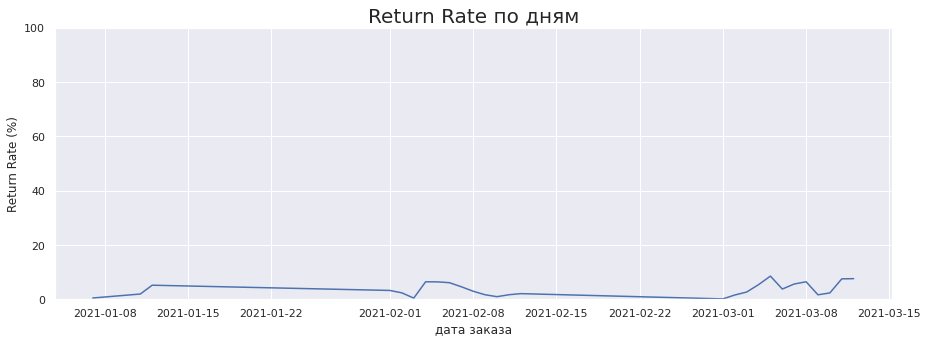

In [82]:
p = sns.lineplot(data=return_order_merged, x='return_date', y='return_rate')
p.set_title("Return Rate по дням",fontsize=20)
p.set_xlabel("дата заказа",fontsize=12)
p.set_ylabel("Return Rate (%)",fontsize=12)
p.set(ylim=(0, 100))
plt.show()


При интерпритации метрики важно учитывать, что данные о возвратах есть только на 1-12 число каждого месяца!

Для рассчета значений метрик по перевозчикам, по кластерам склада и клиента ошибки в датах возврата нам не мешают. Поэтому мы заново соединяем данные по номеру заказа и товара. И мы удаляем данные о возврате с ошибочной датой

In [83]:
return_order_merged_with_errors = logistics_and_products_merged.merge(returns, on = ['number_order','product_ID'], how='left')
return_order_merged_with_errors['amount_return'] = return_order_merged_with_errors.amount_return.fillna(0)

In [84]:
return_order_merged_with_errors['return_rate'] = (return_order_merged_with_errors['amount_return'] 
                                                  / return_order_merged_with_errors['amount'])*100

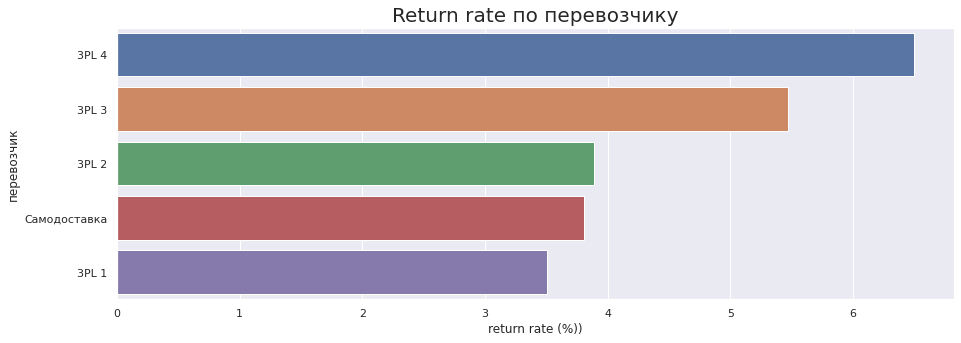

In [85]:
p = sns.barplot(
    data = return_order_merged_with_errors.groupby('carrier_name', as_index=False).return_rate.mean() \
        .sort_values('return_rate', ascending=False),
    y='carrier_name', x='return_rate'
)
p.set_title("Return rate по перевозчику",fontsize=20)
p.set_xlabel("return rate (%))",fontsize=12)
p.set_ylabel("перевозчик",fontsize=12)
#p.set(xlim=(0, 100))
plt.show()

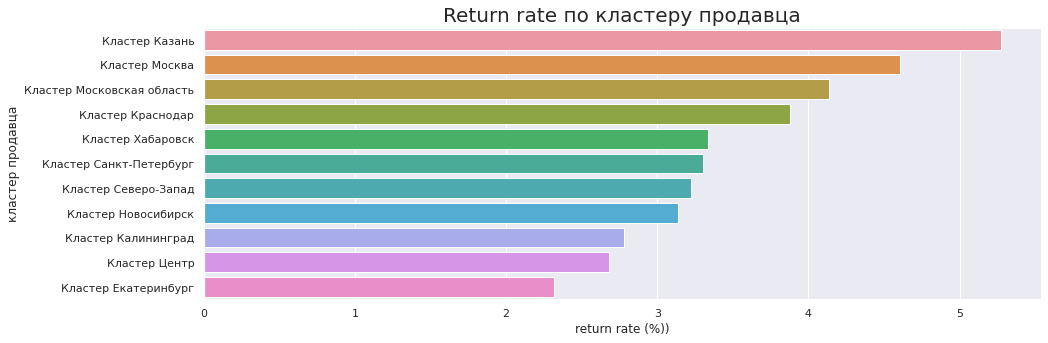

In [86]:

p = sns.barplot(
    data = return_order_merged_with_errors.groupby('warehouse_cluster', as_index=False).return_rate.mean() \
        .sort_values('return_rate', ascending=False),
    y='warehouse_cluster', x='return_rate'
)
p.set_title("Return rate по кластеру продавца",fontsize=20)
p.set_xlabel("return rate (%))",fontsize=12)
p.set_ylabel("кластер продавца",fontsize=12)
#p.set(xlim=(0, 100))
plt.show()



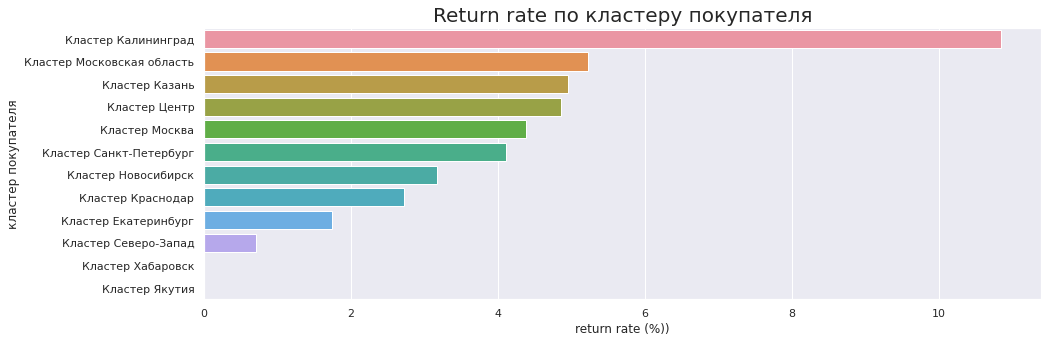

In [87]:
p = sns.barplot(
    data = return_order_merged_with_errors.groupby('customer_cluster', as_index=False).return_rate.mean() \
        .sort_values('return_rate', ascending=False),
    y='customer_cluster', x='return_rate'
)
p.set_title("Return rate по кластеру покупателя",fontsize=20)
p.set_xlabel("return rate (%))",fontsize=12)
p.set_ylabel("кластер покупателя",fontsize=12)
#p.set(xlim=(0, 100))
plt.show()


### 6. Посчитать GMV D-R - метрика, отражающая совокупный объем доставленных заказов за вычетом возвратов, в рублях.
 - Необходимо видеть изменение метрики по дням (для всех дней, которые были раньше, чем дата расчета метрики);
 - Необходимы разрезы по перевозчикам, по типу доставки, по кластерам склада.


In [88]:
#соединяем данные о логистике и товарах с данными о возвратах
all_merged = logistics_and_products_merged.merge(returns[['number_order','product_ID', 'amount_return']], 
                                    on =['number_order','product_ID'], 
                                   how='left')

In [89]:
#заменяем NA на нули в количестве возвращенных товаров
all_merged['amount_return'] = all_merged['amount_return'].fillna(0)

In [90]:
#удаляем строки с товарами, которые не доставили
all_merged = all_merged[all_merged['result_date_order'].notna()]

In [91]:
#считаем итоговую цену за товары с учетом возвратов
all_merged['total_price'] = (all_merged['amount']-all_merged['amount_return'])*all_merged['product_price']

In [92]:
#группируем сумму продах с учетом возвратов по дням
gmv_r_d_days = all_merged.groupby('result_date_order', as_index=False).total_price.sum().sort_values('result_date_order')

In [93]:
# считаем кумулятивкую сумму по дням
gmv_r_d_days['total_price'] = gmv_r_d_days.total_price.cumsum()

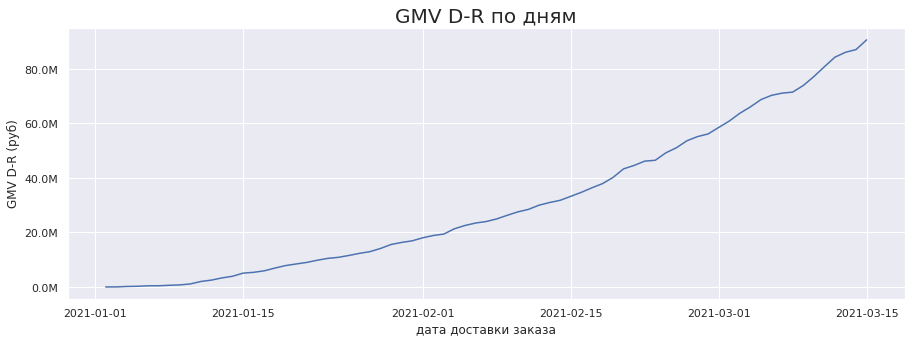

In [97]:
formatter = FuncFormatter(millions)

fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(formatter)


p = sns.lineplot(data=gmv_r_d_days, x='result_date_order', y='total_price')
p.set_title("GMV D-R по дням",fontsize=20)
p.set_xlabel("дата доставки заказа",fontsize=12)
p.set_ylabel("GMV D-R (руб)",fontsize=12)
plt.show()

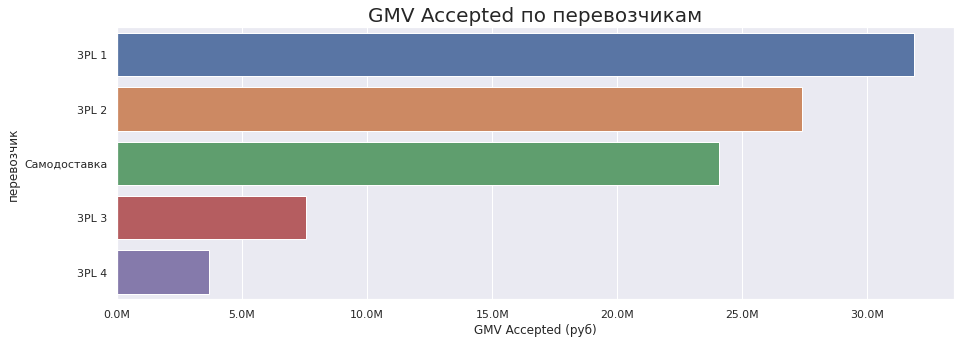

In [98]:
sns.set(rc={'figure.figsize':(15,5)})

#функция, которая переводит занчения на оси Y в миллионы
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)
formatter = FuncFormatter(millions)
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(formatter)


p = sns.barplot(
    data = all_merged.groupby('carrier_name', as_index=False).gmv_accepted.sum() \
        .sort_values('gmv_accepted', ascending=False),
    y='carrier_name', x='gmv_accepted'
)
p.set_title("GMV Accepted по перевозчикам",fontsize=20)
p.set_xlabel("GMV Accepted (руб)",fontsize=12)
p.set_ylabel("перевозчик",fontsize=12)
plt.show()

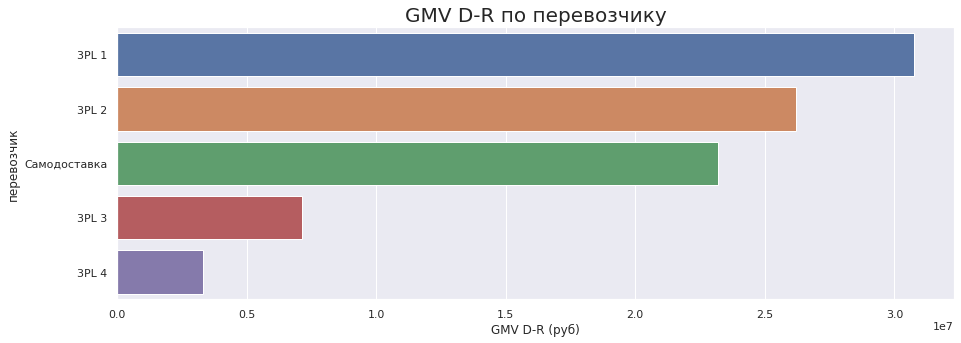

In [99]:
formatter = FuncFormatter(millions)

fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(formatter)


p = sns.barplot(
    data = all_merged.groupby(['carrier_name'], as_index=False).total_price.sum() \
        .sort_values('total_price', ascending=False),
    y='carrier_name', x='total_price'
)
p.set_title("GMV D-R по перевозчику",fontsize=20)
p.set_xlabel("GMV D-R (руб)",fontsize=12)
p.set_ylabel("перевозчик",fontsize=12)
plt.show()

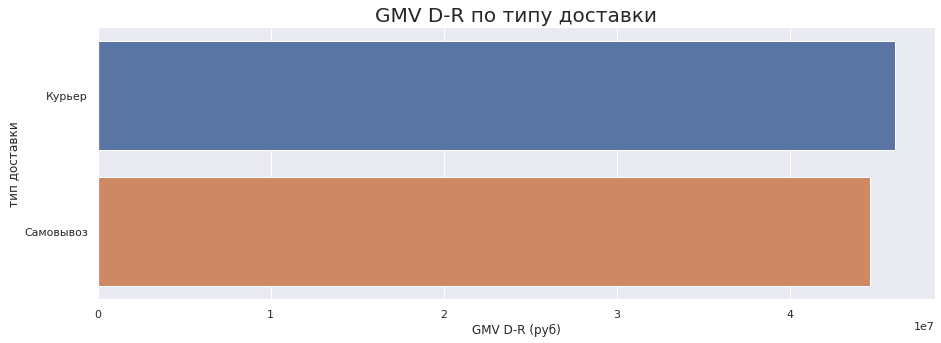

In [100]:
formatter = FuncFormatter(millions)

fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(formatter)


p = sns.barplot(
    data = all_merged.groupby(['delivery_type'], as_index=False).total_price.sum() \
        .sort_values('total_price', ascending=False),
    y='delivery_type', x='total_price'
)
p.set_title("GMV D-R по типу доставки",fontsize=20)
p.set_xlabel("GMV D-R (руб)",fontsize=12)
p.set_ylabel("тип доставки",fontsize=12)
plt.show()

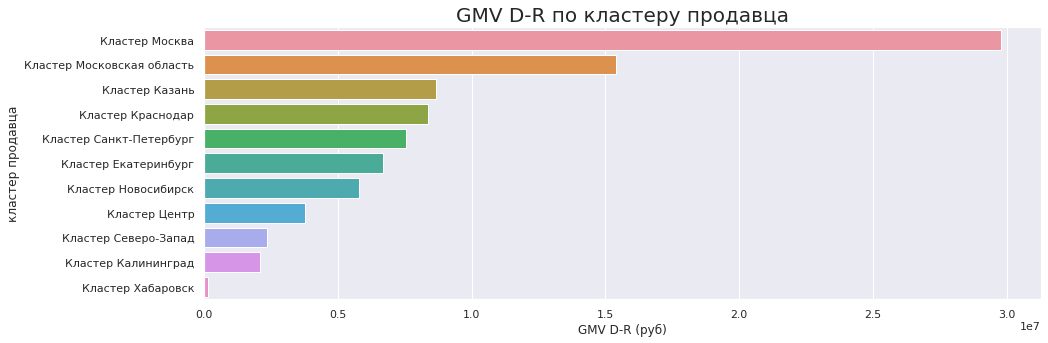

In [101]:
formatter = FuncFormatter(millions)

fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(formatter)


p = sns.barplot(
    data = all_merged.groupby(['warehouse_cluster'], as_index=False).total_price.sum() \
        .sort_values('total_price', ascending=False),
    y='warehouse_cluster', x='total_price'
)
p.set_title("GMV D-R по кластеру продавца",fontsize=20)
p.set_xlabel("GMV D-R (руб)",fontsize=12)
p.set_ylabel("кластер продавца",fontsize=12)
plt.show()